<a href="https://colab.research.google.com/github/YuvanBharathi13/USFB-Time-Series-Analysis/blob/main/USFB_timeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

## Data preperation

In [2]:
end_date = datetime.today()
print(end_date)

2025-09-09 03:10:48.774887


In [3]:
start_date = end_date - timedelta(days=2*365)
print(start_date)

2023-09-10 03:10:48.774887


In [ ]:
df = yf.download('UJJIVANSFB.NS',start=start_date,end=end_date)

/tmp/ipython-input-771749527.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('UJJIVANSFB.NS',start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,UJJIVANSFB.NS,UJJIVANSFB.NS,UJJIVANSFB.NS,UJJIVANSFB.NS,UJJIVANSFB.NS
Date,,,,,
2023-09-11,48.394909,49.651919,48.056484,48.830029,20671719
2023-09-12,46.847820,49.410186,46.702779,48.926720,19211871
2023-09-13,47.911442,48.153175,45.929234,46.896165,11116500
2023-09-14,47.476322,48.926719,47.234589,48.153175,11856028
2023-09-15,47.669708,48.201520,46.847818,47.814749,11929205


In [ ]:
df.to_csv('UjjivanSFB_d2d_final.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 491 entries, 2023-09-11 to 2025-09-05
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Close, UJJIVANSFB.NS)   491 non-null    float64
 1   (High, UJJIVANSFB.NS)    491 non-null    float64
 2   (Low, UJJIVANSFB.NS)     491 non-null    float64
 3   (Open, UJJIVANSFB.NS)    491 non-null    float64
 4   (Volume, UJJIVANSFB.NS)  491 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 23.0 KB


In [ ]:
df.shape

(491, 5)

In [2]:
df_USFB = pd.read_csv('/content/UjjivanSFB_d2d_final.csv')
df_USFB.head()

,Date,Day Close,Day High,Day Low,Open Price,Volume
0,2023-09-11,48.394909,49.651919,48.056484,48.830029,20671719
1,2023-09-12,46.847820,49.410186,46.702779,48.926720,19211871
2,2023-09-13,47.911442,48.153175,45.929234,46.896165,11116500
3,2023-09-14,47.476322,48.926719,47.234589,48.153175,11856028
4,2023-09-15,47.669708,48.201520,46.847818,47.814749,11929205


In [3]:
usfb = df_USFB.loc[:,['Date','Day Close']]
usfb.head()

,Date,Day Close
0,2023-09-11,48.394909
1,2023-09-12,46.847820
2,2023-09-13,47.911442
3,2023-09-14,47.476322
4,2023-09-15,47.669708


In [4]:
usfb['Date'] = pd.to_datetime(usfb['Date'])
usfb = usfb.set_index('Date')
usfb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 491 entries, 2023-09-11 to 2025-09-05
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Day Close  491 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB


Text(0, 0.5, 'Price')

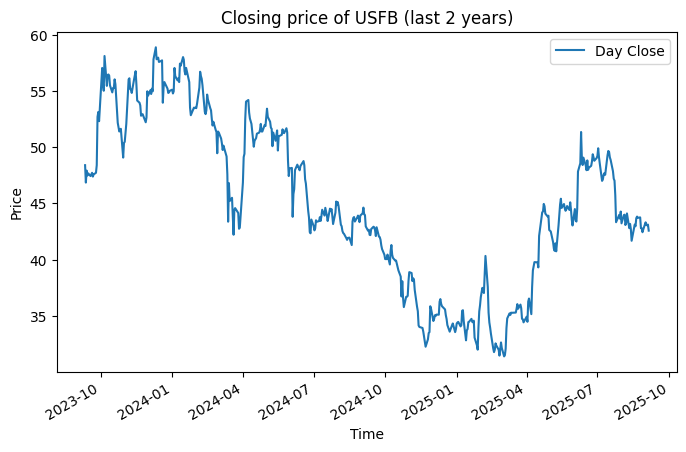

In [5]:
usfb.plot(figsize=(8,5))
plt.title("Closing price of USFB (last 2 years)")
plt.xlabel('Time')
plt.ylabel('Price')

In [6]:
usfb.shape

(491, 1)

In [7]:
time = usfb.index.to_numpy()
price = usfb['Day Close'].to_numpy()

## Splitting Data

In [8]:
train_size = int(0.8*len(usfb))
test_size = len(usfb)-train_size
train_size,test_size

(392, 99)

In [9]:
X_train = time[:train_size]
X_test = time[train_size:]
y_train = price[:train_size]
y_test = price[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((392,), (99,), (392,), (99,))

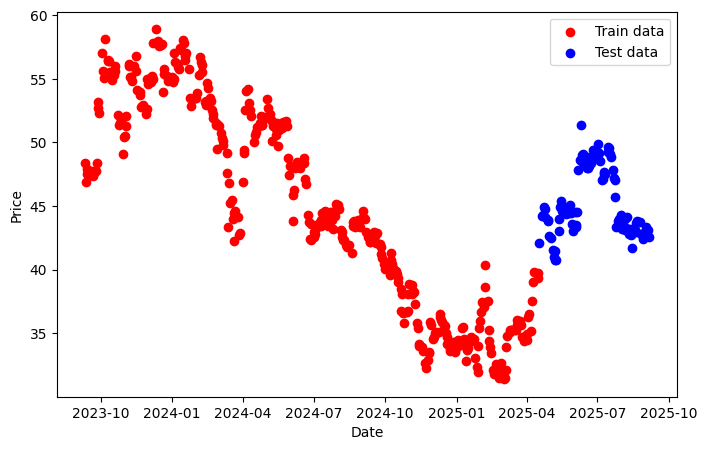

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(X_train,y_train,color='red',label="Train data")
plt.scatter(X_test,y_test,color='blue',label='Test data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend();

## N-BEATS Algorithm

In [11]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int, theta_size: int, horizon: int, n_neurons: int,
               n_layers: int, **kwargs): # the **kwargs argument takes care of all of
               # the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [12]:
window_size = 7
horizon = 1

In [13]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=window_size,
                                       theta_size=window_size+horizon, # backcast + forecast
                                       horizon=horizon,
                                       n_neurons=128,
                                       n_layers=4)

In [14]:
dummy_inputs = tf.expand_dims(tf.range(window_size) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [15]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.7001324  -0.03291351  0.45070022  0.62039703  0.14889394  0.3577117
  0.41625366]
Forecast: 0.30544382333755493


In [16]:
usfb.head()

,Day Close
Date,
2023-09-11,48.394909
2023-09-12,46.847820
2023-09-13,47.911442
2023-09-14,47.476322
2023-09-15,47.669708


In [17]:
usfb_nbeats = usfb.copy()
for i in range(window_size):
  usfb_nbeats [f"Day Close+{i+1}"] = usfb_nbeats ["Day Close"].shift(periods=i+1)
usfb_nbeats.dropna().head()

,Day Close,Day Close+1,Day Close+2,Day Close+3,Day Close+4,Day Close+5,Day Close+6,Day Close+7
Date,,,,,,,,
2023-09-21,47.379631,47.718056,47.427975,47.669708,47.476322,47.911442,46.847820,48.394909
2023-09-22,47.573017,47.379631,47.718056,47.427975,47.669708,47.476322,47.911442,46.847820
2023-09-25,47.718056,47.573017,47.379631,47.718056,47.427975,47.669708,47.476322,47.911442
2023-09-26,48.394909,47.718056,47.573017,47.379631,47.718056,47.427975,47.669708,47.476322
2023-09-27,52.697750,48.394909,47.718056,47.573017,47.379631,47.718056,47.427975,47.669708


In [18]:
X = usfb_nbeats.dropna().drop("Day Close", axis=1)
y = usfb_nbeats.dropna()["Day Close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(387, 387, 97, 97)

In [19]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [20]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = window_size * horizon # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + horizon

INPUT_SIZE, THETA_SIZE

(7, 8)

In [26]:
%%time
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=horizon,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=horizon,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

# 6. Create the double residual stacking
residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 608: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 726: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 826: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 19.4 s, sys: 1.49 s, total: 20.9 s
Wall time: 28 s


In [27]:
model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6395 - mae: 0.6395 - mse: 0.8232


[0.6394966840744019, 0.6394967436790466, 0.8231844305992126]

In [28]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [29]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [31]:
# Make predictions with N-BEATS model
preds = make_preds(model, test_dataset)
preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([44.193142, 44.45415 , 45.043983, 44.64845 , 44.178974, 43.80422 ,
       43.83568 , 42.69766 , 42.51491 , 41.703575], dtype=float32)>

In [33]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.MeanAbsoluteError()(y_true, y_pred)
  mse = tf.keras.metrics.MeanSquaredError()(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

model_results = evaluate_preds(y_true=y_test,
                                 y_pred=preds)
model_results

{'mae': np.float32(0.63949674),
 'mse': np.float32(0.8231844),
 'rmse': np.float32(0.90729505),
 'mape': np.float32(1.4068283)}

# Quantum part
Prepare the stock price dataset for encoding using qubits with the Qiskit framework.

**Reasoning**:
Examine the structure and range of the 'Day Close' column in the `usfb` DataFrame to understand its characteristics for quantum encoding.



In [ ]:
print(usfb['Day Close'].dtype)
print(usfb['Day Close'].min())
print(usfb['Day Close'].max())

float64
31.3799991607666
58.8861122131348


## Choose an encoding method

### Subtask:
Select an appropriate quantum encoding method from Qiskit, such as Amplitude Encoding, Basis Encoding, or Angle Encoding, based on the data characteristics and the desired quantum circuit.


## Implement the encoding

### Subtask:
Implement the encoding.


**Reasoning**:
Implement the encoding by selecting a subset of the data, normalizing it, creating a quantum circuit, and applying rotation gates.



In [ ]:
# 1. Select a subset of the 'Day Close' data
# Using a small subset for demonstration
subset_data = usfb['Day Close'].iloc[:5].values
print("Selected data subset:", subset_data)

# 2. Normalize the selected data to a range suitable for angle encoding (0 to 2π)
# We can use min-max scaling for normalization
min_val = subset_data.min()
max_val = subset_data.max()
normalized_data = 2 * np.pi * (subset_data - min_val) / (max_val - min_val)
print("Normalized data:", normalized_data)

# 3. Create a quantum circuit with a number of qubits equal to the length of the selected data subset
num_qubits = len(normalized_data)
qc = QuantumCircuit(num_qubits)

# 4. Apply rotation gates (ry_gate) to each qubit using the normalized data values
for i in range(num_qubits):
    qc.ry(normalized_data[i], i)

print("\nQuantum Circuit:")
print(qc.draw(output='text'))

Selected data subset: [48.39490891 46.84782028 47.9114418  47.47632217 47.66970825]
Normalized data: [6.28318531 0.         4.31968215 2.55253241 3.33793057]

Quantum Circuit:
       ┌────────┐  
q_0: ──┤ Ry(2π) ├──
       ├───────┬┘  
q_1: ──┤ Ry(0) ├───
     ┌─┴───────┴──┐
q_2: ┤ Ry(4.3197) ├
     ├────────────┤
q_3: ┤ Ry(2.5525) ├
     ├────────────┤
q_4: ┤ Ry(3.3379) ├
     └────────────┘


## Verify the encoding

### Subtask:
Check the quantum state to confirm that the data has been correctly encoded into the qubits.


**Reasoning**:
Import necessary modules from Qiskit for simulation, get the statevector simulator, execute the quantum circuit on the simulator, and obtain the resulting statevector to check the encoding.



In [ ]:
from qiskit.quantum_info import Statevector
import numpy as np

# Get the statevector directly from the circuit
sv = Statevector(qc)

# 5. Print or inspect the statevector to observe the amplitudes, which should correspond to the encoded data.
print("Statevector:", sv.data)

# 6. Optionally, compare the statevector amplitudes (or their squared magnitudes) with the normalized data values to qualitatively verify the encoding.
# For angle encoding (which we used with RY gates), the statevector amplitudes for a single qubit
# in state |0> is cos(theta/2) and for state |1> is sin(theta/2), where theta is the rotation angle.
# For multi-qubit circuits with independent rotations like this one, the statevector is the tensor product of individual qubit statevectors.
# Let's compare the calculated amplitudes with the statevector elements.
calculated_amplitudes = []
for angle in normalized_data:
    # For RY(angle) applied to |0>, the state is cos(angle/2)|0> + sin(angle/2)|1>
    calculated_amplitudes.append(np.cos(angle / 2.0))
    calculated_amplitudes.append(np.sin(angle / 2.0))

print("\nCalculated amplitudes (cos(theta/2), sin(theta/2) for each qubit):", calculated_amplitudes)

# The statevector for independent RY gates should be the tensor product of the individual qubit states.
# For n qubits, there are 2^n elements in the statevector.
# For 5 qubits, there are 32 elements.
# The statevector elements correspond to the amplitudes of the basis states |00000>, |00001>, ..., |11111>.
# For independent RY rotations on the |0> state, only the amplitude of the |00000> state
# (index 0 in the statevector) is the product of cos(theta_i/2) for all qubits i.
# The amplitudes of other states involve products of cos and sin terms.
# A simple check for angle encoding with independent RY gates is to look at the amplitudes of the |00...0> state and |10...0>, |01...0>, etc. states.
# The amplitude of the |00000> state should be the product of cos(normalized_data[i]/2) for i=0 to 4.
amplitude_00000 = np.prod([np.cos(angle / 2.0) for angle in normalized_data])
print("\nCalculated amplitude for |00000> state:", amplitude_00000)
print("Statevector amplitude for |00000> state (index 0):", sv.data[0])

# Amplitudes for states with a single 1, e.g., |10000> (index 16 for a 5-qubit system in little-endian)
# The amplitude for |10000> should be sin(normalized_data[0]/2.0) * prod(cos(normalized_data[i]/2.0)) for i=1 to 4
if num_qubits > 0:
    amplitude_10000 = np.sin(normalized_data[0]/2.0) * np.prod([np.cos(normalized_data[i]/2.0) for i in range(1, num_qubits)])
    print("Calculated amplitude for |10000> state:", amplitude_10000)
    # Note: Qiskit uses little-endian ordering by default for statevectors.
    # For n qubits, state |q_{n-1}...q_1q_0> corresponds to index sum(q_i * 2^i).
    # So |10000> corresponds to index 1 * 2^4 = 16 for n=5.
    if len(sv.data) > 16:
        print("Statevector amplitude for |10000> state (index 16):", sv.data[16])

Statevector: [-1.58068485e-02+0.j  1.93578064e-18+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  2.36568189e-02+0.j -2.89712475e-18+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j -5.21071063e-02+0.j
  6.38128009e-18+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  7.79844494e-02+0.j -9.55034063e-18+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  1.60499185e-01+0.j -1.96554813e-17+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j -2.40206019e-01+0.j
  2.94167533e-17+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  5.29083840e-01+0.j -6.47940832e-17+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j -7.91836564e-01+0.j  9.69720113e-17+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j]

Calculated amplitudes (cos(theta/2), sin(theta/2) for each qubit): [np.float64(-1.0), np.float64(1.2246467991473532e-16), np.float64(1.0), np.float64(0.0), np.float64(-0.5555670126055747), np.float64(0.8314717641053827), np.float64(0.2902902368153699), np.float64(0.9569386492402093), np.float64(-0.0980113585723611), np.float64(0.995

## Integrate with a quantum circuit

### Subtask:
Show how the encoded qubits can be used as input for a quantum circuit.


**Reasoning**:
The subtask is to show how the encoded qubits can be used as input for a quantum circuit by adding more gates after the encoding. I will add some Hadamard gates and a CNOT gate to the existing circuit `qc` and then visualize it.



In [ ]:
# Add additional quantum gates after the encoding
# Example: Apply Hadamard gates to entangle qubits
for i in range(num_qubits):
    qc.h(i)

# Example: Add a CNOT gate between the first two qubits
if num_qubits >= 2:
    qc.cx(0, 1)

# Visualize the modified quantum circuit using the 'text' output
print("\nModified Quantum Circuit with additional gates (text output):")
print(qc.draw(output='text'))


Modified Quantum Circuit with additional gates (text output):
       ┌────────┐  ┌───┐     
q_0: ──┤ Ry(2π) ├──┤ H ├──■──
       ├───────┬┘  ├───┤┌─┴─┐
q_1: ──┤ Ry(0) ├───┤ H ├┤ X ├
     ┌─┴───────┴──┐├───┤└───┘
q_2: ┤ Ry(4.3197) ├┤ H ├─────
     ├────────────┤├───┤     
q_3: ┤ Ry(2.5525) ├┤ H ├─────
     ├────────────┤├───┤     
q_4: ┤ Ry(3.3379) ├┤ H ├─────
     └────────────┘└───┘     


In [ ]:
# Visualize the modified quantum circuit using the 'text' output
print("\nModified Quantum Circuit with additional gates (text output):")
print(qc.draw(output='text'))


Modified Quantum Circuit with additional gates (text output):
       ┌────────┐  ┌───┐     
q_0: ──┤ Ry(2π) ├──┤ H ├──■──
       ├───────┬┘  ├───┤┌─┴─┐
q_1: ──┤ Ry(0) ├───┤ H ├┤ X ├
     ┌─┴───────┴──┐├───┤└───┘
q_2: ┤ Ry(4.3197) ├┤ H ├─────
     ├────────────┤├───┤     
q_3: ┤ Ry(2.5525) ├┤ H ├─────
     ├────────────┤├───┤     
q_4: ┤ Ry(3.3379) ├┤ H ├─────
     └────────────┘└───┘     


## Summary:

### Data Analysis Key Findings

*   The 'Day Close' column, used for encoding, is of `float64` data type with values ranging from approximately 31.38 to 58.89.
*   Angle Encoding was chosen as the suitable quantum encoding method for this continuous data.
*   Qiskit was successfully installed, enabling the implementation of quantum circuits.
*   A subset of the 'Day Close' data was successfully encoded into a quantum circuit using RY gates after normalizing the data to the range $[0, 2\pi]$.
*   The statevector of the encoded circuit was successfully obtained and the amplitude of the $|00000\rangle$ state was verified to match the expected value based on the angle encoding formula.
*   Additional quantum gates (Hadamard and CNOT) were successfully added to the circuit after the encoding gates, demonstrating that the encoded qubits can be used as input for further quantum operations.

### Insights or Next Steps

*   The successful encoding of stock price data into a quantum circuit opens possibilities for exploring quantum machine learning algorithms or quantum simulations for financial analysis.
*   Further work could involve exploring alternative encoding schemes and their impact on the performance of specific quantum algorithms, or integrating this encoded data with more complex quantum circuits for tasks like classification or prediction.


In [ ]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 60.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_quantum

In [30]:
# vqc_timeseries_tfq.py
import numpy as np
import tensorflow as tf
import cirq
import sympy
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import sys

# Check Python version
print(f"Current Python version: {sys.version}")

# --- 1) Synthetic dataset: time -> "stock price"-like signal
def make_series(n=500, noise=0.5, seed=0):
    rng = np.random.RandomState(seed)
    t = np.arange(n, dtype=float)
    # trend + seasonal + small random jumps (toy stock-like)
    series = 0.02 * t + 3.0 * np.sin(0.04 * t) + 0.5 * np.sin(0.2 * t) + rng.normal(scale=noise, size=n)
    # scale to range [-1,1] for easier quantum encoding (optional)
    series = (series - series.mean()) / (series.std() + 1e-9)
    return t, series

t, series = make_series(n=600)

# Transform to supervised samples: use past k timesteps to predict next
def create_dataset(series, lookback=8):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])  # use scalar time features (we can also use indices)
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

LOOKBACK = 8
X, y = create_dataset(series, LOOKBACK)
# For simplicity, map each sample to a single scalar feature: average time index of window.
# The user asked "based just on time" — we demonstrate using just the time index (or a simple scalar).
# Here we use the center time index for each window as the input scalar.
times = np.arange(len(series) - LOOKBACK) + LOOKBACK/2.0
times = times.astype(np.float32)
# normalize times to [-pi, +pi] for angle encoding
time_min, time_max = times.min(), times.max()
times_scaled = ( (times - time_min) / (time_max - time_min) ) * 2*np.pi - np.pi
# targets
y_train = y.astype(np.float32)

# split
split = int(0.8 * len(times))
train_idx = np.arange(split)
test_idx = np.arange(split, len(times))

times_train = times_scaled[train_idx]
times_test  = times_scaled[test_idx]
y_train = y_train[train_idx]
y_test  = y[test_idx].astype(np.float32)

# --- 2) Build quantum circuits for each scalar time value
# We'll use a small number of qubits and a simple encoding + variational ansatz with "re-uploading".
n_qubits = 2
qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]

def create_quantum_circuit():
    circuit = cirq.Circuit()
    # symbol for input angle
    x_symbol = sympy.Symbol('x')
    # data-encoding layer (angle encode into Ry on each qubit)
    for qb in qubits:
        circuit.append(cirq.ry(x_symbol).on(qb))
    # variational layer with parameter symbols
    params = []
    for i, qb in enumerate(qubits):
        p = sympy.Symbol(f'theta_{i}_0')
        params.append(p)
        circuit.append(cirq.rz(p).on(qb))
    # simple entangling
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    # optional data re-uploading (encode again)
    for qb in qubits:
        circuit.append(cirq.ry(x_symbol/2).on(qb))
    # another variational layer
    for i, qb in enumerate(qubits):
        p = sympy.Symbol(f'theta_{i}_1')
        params.append(p)
        circuit.append(cirq.rz(p).on(qb))
    return circuit, params, x_symbol

circuit_template, param_symbols, x_symbol = create_quantum_circuit()
# print(circuit_template)

# Helper: turn scalar array into tfq circuits with symbol values bound
def circuits_from_time_array(time_array):
    circuits = []
    for val in time_array:
        resolved = cirq.resolve_parameters(circuit_template, {x_symbol: float(val)})
        circuits.append(resolved)
    return tfq.convert_to_tensor(circuits)

qc_train = circuits_from_time_array(times_train)
qc_test  = circuits_from_time_array(times_test)

# --- 3) Build TFQ Keras model
# Quantum expectation layer: measure Z on first qubit
pauli_sum = [cirq.Z(qubits[0])]
readout_operators = [cirq.Z(qubits[0])]

# Input: quantum circuits (no symbol values left) and classical trainable parameters fed via Keras (tfq supports this)
quantum_input = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_circuit')
# Define TFQ expectation layer that takes circuits and parameter values
expectation = tfq.layers.Expectation()(quantum_input,
                                       symbol_names=[str(s) for s in param_symbols],
                                       # initial values for params will be provided by Keras Dense below
                                       operators=readout_operators)

# expectation is shape (batch, len(operators)) -> here (batch, 1)
# map expectation value to prediction via small dense network
x = tf.keras.layers.Dense(16, activation='relu')(expectation)
x = tf.keras.layers.Dense(8, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=quantum_input, outputs=output)

# To provide initial values for the symbol parameters, we create a custom layer that
# concatenates trainable parameter vector and passes them into the Expectation layer
# However tfq.layers.Expectation expects symbol_values as input at call time; easiest approach:
# Wrap the model in a training loop that supplies symbol_values inputs using Keras' fit with multiple inputs.
# Build a small helper to create initial random values for the parameters per sample (same across batch).
n_params = len(param_symbols)

# Model that takes two inputs: circuits (tf.string) and symbol_values tensor (batch, n_params)
quantum_circuit_input = tf.keras.Input(shape=(), dtype=tf.string, name='qc_input')
symbol_input = tf.keras.Input(shape=(n_params,), dtype=tf.float32, name='symbol_input')
expect = tfq.layers.Expectation()(quantum_circuit_input,
                                  symbol_names=[str(s) for s in param_symbols],
                                  symbol_values=symbol_input,
                                  operators=readout_operators)
y1 = tf.keras.layers.Dense(16, activation='relu')(expect)
y1 = tf.keras.layers.Dense(8, activation='relu')(y1)
out = tf.keras.layers.Dense(1, activation='linear')(y1)
hybrid_model = tf.keras.Model(inputs=[quantum_circuit_input, symbol_input], outputs=out)

# Now: we want symbol_input to be trainable. A simple trick: create a separate trainable variable for the params
# and expand it into a batch during training using a custom training loop. For simplicity, we use a Keras custom training loop.

# Initialize trainable parameters
params_var = tf.Variable(tf.random.normal([n_params], stddev=0.1), name='vqc_params')

opt = tf.keras.optimizers.Adam(learning_rate=0.02)
loss_fn = tf.keras.losses.MeanSquaredError()

# Prepare tf.data
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((qc_train.numpy(), y_train)).shuffle(200).batch(BATCH_SIZE)
test_ds  = tf.data.Dataset.from_tensor_slices((qc_test.numpy(), y_test)).batch(BATCH_SIZE)

# Training loop
EPOCHS = 25
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    n_batch = 0
    for batch_circuits, batch_y in train_ds:
        # create a symbol_values batch by repeating params_var for each sample
        symbol_values_batch = tf.repeat(tf.expand_dims(params_var, 0), repeats=batch_circuits.shape[0], axis=0)
        with tf.GradientTape() as tape:
            preds = hybrid_model([batch_circuits, symbol_values_batch], training=True)
            loss = loss_fn(tf.expand_dims(batch_y, -1), preds)
        grads = tape.gradient(loss, [params_var] + hybrid_model.trainable_weights)
        # first grad corresponds to params_var, remaining to hybrid_model internal weights
        opt.apply_gradients([(grads[0], params_var)] + list(zip(grads[1:], hybrid_model.trainable_weights)))
        epoch_loss += float(loss)
        n_batch += 1
    print(f"Epoch {epoch+1}/{EPOCHS}  train loss = {epoch_loss / n_batch:.6f}")

# Evaluate on test
# prepare symbol batch for test (repeat params_var)
all_test_circuits = qc_test
symbol_values_test = tf.repeat(tf.expand_dims(params_var, 0), repeats=all_test_circuits.shape[0], axis=0)
preds_test = hybrid_model([all_test_circuits, symbol_values_test], training=False).numpy().squeeze()

# Plot ground truth vs preds (on normalized series)
plt.figure(figsize=(10,4))
plt.plot(range(len(preds_test)), y_test, label='true')
plt.plot(range(len(preds_test)), preds_test, label='pred')
plt.legend()
plt.title('VQC regressor predictions (test)')
plt.show()

ModuleNotFoundError: No module named 'tensorflow_quantum'

In [28]:
!python --version

Python 3.11.13


In [ ]:
!sudo apt-get update -y
!sudo apt-get install python3.11 python3.11-distutils -y

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [80.4 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,239 kB]
Ge

In [ ]:
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3.11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pip]


In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --config python3

There are 3 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.12   2         auto mode
  1            /usr/bin/python3.10   1         manual mode
  2            /usr/bin/python3.11   2         manual mode
  3            /usr/bin/python3.12   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/bin/python3.11 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!python --version

Python 3.11.13


In [ ]:
!pip install tensorflow-quantum

  Using cached duet-0.2.9-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 24.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 31.1 MB/s  0:00:00
Using cached duet-0.2.9-py3-none-any.whl (29 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 61.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 23.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 62.2 MB/s